In [1]:
%pip install --upgrade google-cloud-aiplatform==1.35.0 google-cloud-documentai==2.20.1 backoff==2.2.1 --user
%pip install PyPDF2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [214]:
%%writefile functions.py

import sys

if "google.colab" in sys.modules:
    # Automatically restart kernel after installs so that your environment can access the new packages
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
else:
    # Otherwise, attempt to discover local credentials as described on https://cloud.google.com/docs/authentication/application-default-credentials
    pass

Overwriting functions.py


In [215]:
%%writefile -a functions.py
from __future__ import annotations
import backoff
from tenacity import retry, stop_after_attempt, wait_random_exponential
from google.api_core.exceptions import ResourceExhausted
from google.api_core.client_options import ClientOptions
from google.api_core.exceptions import AlreadyExists
from google.cloud import documentai
import numpy as np
import glob
import os
from typing import Dict, List
import pandas as pd
from logging import error
import re
import textwrap
from typing import Tuple, List
import vertexai
from vertexai.language_models import TextEmbeddingModel, TextGenerationModel
from PyPDF2 import PdfReader, PdfWriter
import json
import time
import numpy as np
import glob

Appending to functions.py


## Pre-configuration of GCP project

In [216]:
%%writefile -a functions.py

#Once the project is created in the console, extract the parameters here
PROJECT_ID = !gcloud config get project
PROJECT_ID = PROJECT_ID.n
LOCATION = "europe-west2"
LOCATION_DEPLOY = "europe-west2" #Location to deploy GCP resources

#!gcloud services enable documentai.googleapis.com storage.googleapis.com aiplatform.googleapis.com

Appending to functions.py


In [12]:
client_options

ClientOptions: {'api_endpoint': 'europe-west2-documentai.googleapis.com', 'client_cert_source': None, 'client_encrypted_cert_source': None, 'quota_project_id': None, 'credentials_file': None, 'scopes': None, 'api_key': None, 'api_audience': None}

The processor is now ready to be defined by calling the document AI API. Code source: https://github.com/GoogleCloudPlatform/generative-ai/blob/main/language/use-cases/document-qa/question_answering_documentai_vector_store_palm.ipynb.


## 1. Create the processor


"There are two types of Document AI processors:

Pre-trained processors: These processors are pre-trained on a large dataset of documents and can be used to perform common document processing tasks, such as Optical Character Recognition (OCR), form parsing, and entity extraction.
Custom processors: These processors can be trained on your own dataset of documents to perform specific tasks that are not covered by the pre-trained processors.
Refer to Full processor and detail list for all supported processors.

Processors take a PDF or image file as input and output the data in the Document format."

In [217]:
%%writefile -a functions.py
# Edit these variables before running the code.
project_id = PROJECT_ID

# See https://cloud.google.com/document-ai/docs/regions for all options.
location = LOCATION

# Must be unique per project, e.g.: "My Processor"
processor_display_name = "processor1"

# You must set the `api_endpoint` if you use a location other than "us".
client_options = ClientOptions(api_endpoint=f"{location}-documentai.googleapis.com")


#1. Create the processor: you can not create multiple processors with the same display name
def create_processor(
    project_id: str, location: str, processor_display_name: str
) -> documentai.Processor:
    client = documentai.DocumentProcessorServiceClient(client_options=client_options)

    # The full resource name of the location
    # e.g.: projects/project_id/locations/location
    parent = client.common_location_path(project_id, location)

    # Create a processor
    return client.create_processor(
        parent=parent,
        processor=documentai.Processor(
            display_name=processor_display_name, type_="OCR_PROCESSOR" #we are using the pre-trained OCR processor
        ),
    )


try:
    processor = create_processor(project_id, location, processor_display_name)
    print(f"Created Processor {processor.name}")
except AlreadyExists as e:
    print(
        f"Processor already exits, change the processor name and rerun this code. {e.message}"
    )

    

#2. Define process document function which takes the processor name and file path of the document and extracts the text from the document.  
def process_document(
    processor_name: str,
    file_path: str,
) -> documentai.Document:
    client = documentai.DocumentProcessorServiceClient(client_options=client_options)

    # Read the file into memory
    with open(file_path, "rb") as image:
        image_content = image.read()

    # Load Binary Data into Document AI RawDocument Object
    raw_document = documentai.RawDocument(
        content=image_content, mime_type="application/pdf"
    )

    # Configure the process request
    request = documentai.ProcessRequest(name=processor_name, raw_document=raw_document)

    result = client.process_document(request=request)

    return result.document



Appending to functions.py


The document AI processor set a limit of 15 pages of PDF to be processed at once. The following function will split the initial PDF into pdfs of 15 pages max. The created pdfs are saved under new folder pdf_chunks with path labelled 1 to n (n=number of pdf chunks)

In [224]:
%%writefile text_extraction_from_pdf.py
def split_and_save_pdf(input_pdf_path: str, max_pages_per_file: int):
    # Create a folder to store the split PDFs
    output_folder = os.path.join(os.path.dirname(input_pdf_path), 'pdf_chunks')
    os.makedirs(output_folder, exist_ok=True)
    
    pdf_paths = []
    
    # Open the input PDF
    with open(input_pdf_path, 'rb') as pdf_file:
        pdf_reader = PdfReader(pdf_file)
        num_pages = len(pdf_reader.pages)
        
        # Calculate the number of files needed
        num_files = (num_pages + max_pages_per_file - 1) // max_pages_per_file
        
        # Split the PDF into multiple files
        for i in range(num_files):
            start_page = i * max_pages_per_file
            end_page = min((i + 1) * max_pages_per_file, num_pages)
            
            pdf_writer = PdfWriter()
            # Etract pages and add to tthe new PDF writer
            for page_num in range(start_page,end_page):
                pdf_writer.add_page(pdf_reader.pages[page_num])
            
            output_pdf_path = os.path.join(output_folder,f'pdf{i+1}.pdf')
            
            # Save the new PDF file
            with open(output_pdf_path, 'wb') as output_pdf:
                pdf_writer.write(output_pdf)
                
            print(f'Saved:{output_pdf_path}')
            pdf_paths.append(output_pdf_path)
            
    return pdf_paths
                

Writing text_extraction_from_pdf.py


We are now ready to extract the text from our pdf. 

## 2. Text extraction from PDF

In [219]:
%%writefile -a functions.py
def text_extraction_from_pdf(input_pdf_path):
    max_pages_per_file = 15 # Set the desired maximum number of pages per file
    processor_name = processor.name # Assign the created processor name


    # 1. Split the PDF into pdf chunks of 15 pages max and save their paths 
    pdf_paths = split_and_save_pdf(input_pdf_path, max_pages_per_file)


    # 2. Iterate through the pdf chunks and extract and join their text
    texts = []
    for pdf_path in pdf_paths:
        try: 
            document = process_document(processor_name, file_path=pdf_path)
            texts.append(document.text)
        except Exception as e:
            print("API Resouces temporarily exhausted. Waiting for 60 secs")
            time.sleep(60)
    
    return ''.join(texts) # returns full extracted text, joined form each pdf chunks 
    

Appending to functions.py


## 3. Text chunking

The extracted text from the PDF is chunked following these steps: 

    - Split into sentences
    - Create paragraphs based on number of element per chunk which can be set up manually 
    - Create DataFrame where each row is a paragraph

In [226]:
%%writefile 3_text_chunking.py
#split into sentences
def text_to_sentences(text):
    sentences = text.split('\n')
    return sentences

def create_sentence_chunks(sentences, chunk_size):
    sentence_chunks = [sentences[i:i+chunk_size] for i in range(0, len(sentences), chunk_size)]
    return sentence_chunks

def text_to_paragraph(text, chunk_size):
    return create_sentence_chunks(text_to_sentences(text), chunk_size)

def paragraphs_to_df(paragraphs):
    data = []

    # Iterate through sentence chunks
    for idx, chunk in enumerate(sentence_chunks, start=1):
        # Merge sentences within the chunk into one string
        merged_text = ''.join(chunk)
        # Append data to the list
        data.append({
            'paragraph_number':idx,
            'text':merged_text
        })
    # DataFrame with different paragraphs
    return pd.DataFrame(data)
    
# chunk_size = 40
# sentence_chunks = text_to_paragraph(text, chunk_size)
# df = paragraphs_to_df(sentence_chunks)

Writing 3_text_chunking.py


## 4. Create the embeddings

For each paragraph in the DataFrame, the gecko embedding model from GCP is applied to create the corresponding embeddign vector.

In [227]:
%%writefile 4_create_embeddings.py
# Call the GCP models
generation_model = TextGenerationModel.from_pretrained("text-bison@002")
embedding_model = TextEmbeddingModel.from_pretrained("textembedding-gecko@002")


# This decorator is used to handle exceptions and apply exponential backoff in case of ResourceExhausted errors.
# It means the function will be retried with increasing time intervals in case of this specific exception.
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(5))
def text_generation_model_with_backoff(**kwargs):
    return generation_model.predict(**kwargs).text


def get_embedding(text):
    get_embedding.counter += 1
    try:
        if get_embedding.counter % 100 == 0:
            time.sleep(3)
        return embedding_model.get_embeddings([text])[0].values #Send request to embedding model
    except:
        print('waiting for 60 secs')
        time.sleep(60)
        return embedding_model.get_embeddings([text])[0].values #Send request to embedding model


Writing 4_create_embeddings.py


In [222]:
get_embedding.counter = 0

# Create embedding for each paragraph in the DataFrame. This may take several minutes to complete.
df["embedding"] = df["text"].apply(lambda x: get_embedding(x))

Appending to functions.py


The same embedding model is applied on the question of the user.

In [228]:

%%writefile -a 4_create_embeddings.py
def get_context_from_question(
    question: str, vector_store: pd.DataFrame, sort_index_value: int = 3
) -> Tuple[str, pd.DataFrame]:
    query_vector = np.array(get_embedding(question))
    vector_store["dot_product"] = vector_store["embedding"].apply(
        lambda row: np.dot(row, query_vector)
    )
    # Similarity matching by dot product 
    top_matched = vector_store.sort_values(by="dot_product", ascending=False)[
        :sort_index_value
    ].index
    
    top_matched_df = vector_store.loc[top_matched, ["paragraph_number", "text"]]
    context = "\n".join(top_matched_df["text"].values)
    
    return context, top_matched_df

Appending to 4_create_embeddings.py


## Usage

## 1. Text preparation for Q&A


In [206]:
# Use on Breeze Motor's report text 
text = df_companies.iloc[1,5]

# 1. Chunk the text into paragraph and transform into a df: when using a size 40, chunk 3 has the relevant info
chunk_size = 20
sentence_chunks = text_to_paragraph(text, chunk_size)
df = paragraphs_to_df(sentence_chunks)
# df = df.drop(df.index[-1]) only for index 8 special steel group

# 2. Get the embeddings vector using Gecko for each chunk stored in a new column p
get_embedding.counter = 0
df["embedding"] = df["text"].apply(lambda x: get_embedding(x)) # This may take several minutes to complete.
df

,paragraph_number,text,embedding
0,1,Breeze Motor CompanyLimitedRegistered number: ...,"[0.002161432756111026, -0.01833339035511017, -..."
1,2,5th Floor Merck HouseSeldown LanePooleDorsetBH...,"[-0.013716379180550575, -0.015292800031602383,..."
2,3,Group Strategic Report1-5Director's Report6-8I...,"[2.6124604119104333e-05, -0.023879574611783028..."
3,4,BREEZE MOTOR COMPANY LIMITEDGROUP STRATEGIC RE...,"[0.00749810878187418, -0.02356719598174095, -0..."
4,5,to look to grow the business where the managem...,"[7.044868834782392e-05, 0.0037446788046509027,..."
5,6,We are reliant on our new vehicle product from...,"[-0.0017400288488715887, -0.017299499362707138..."
6,7,Liquidity riskThe Group seeks to manage financ...,"[0.0014859773218631744, -0.011692143976688385,..."
7,8,Operating profit margin % 3.3 1.6 The ratio of...,"[-0.015331121161580086, -0.022613119333982468,..."
8,9,required by the regulations for which we deem ...,"[-0.0273957047611475, -0.018486086279153824, -..."
9,10,Vehicle Fuel Combustion Emissions. Scope 1 (tC...,"[-0.010366363450884819, -0.03394094109535217, ..."


## 2. Q&A

In [207]:
%%time
# your question for the documents
question = "Give me the scope 1 emissions"

# get the custom relevant chunks from all the chunks in vector store.
context, top_matched_df = get_context_from_question(
    question,
    vector_store=df,
    sort_index_value=3,  # Top N results to pick from embedding vector search
)
prompt = f""" Answer the question as precise as possible using the provided context. \n\n
            Context: \n {context}?\n
            Question: \n {question} \n
            Answer:
  
  """

# Call the PaLM API on the prompt.
print(question)
print("PaLM Predicted:", text_generation_model_with_backoff(prompt=prompt), "\n\n")
# top 5 data that has been picked by model based on user question. This becomes the context.
print(top_matched_df)

# df.iloc[2,1] + df.iloc [7,1]

# your question for the documents
question = "Give me the scope 2 emissions"

# get the custom relevant chunks from all the chunks in vector store.
context, top_matched_df = get_context_from_question(
    question,
    vector_store=df,
    sort_index_value=3,  # Top N results to pick from embedding vector search
)
prompt = f""" Answer the question as precise as possible using the provided context. \n\n
            Context: \n {context}?\n
            Question: \n {question} \n
            Answer:
  
  """

# Call the PaLM API on the prompt.
print(question)
print("PaLM Predicted:", text_generation_model_with_backoff(prompt=prompt), "\n\n")
# top 5 data that has been picked by model based on user question. This becomes the context.
print(top_matched_df)

# your question for the documents
question = "Give me the scope 3 emissions"

# get the custom relevant chunks from all the chunks in vector store.
context, top_matched_df = get_context_from_question(
    question,
    vector_store=df,
    sort_index_value=3,  # Top N results to pick from embedding vector search
)
prompt = f""" Answer the question as precise as possible using the provided context. \n\n
            Context: \n {context}?\n
            Question: \n {question} \n
            Answer:
  
  """

# Call the PaLM API on the prompt.
print(question)
print("PaLM Predicted:", text_generation_model_with_backoff(prompt=prompt), "\n\n")
# top 5 data that has been picked by model based on user question. This becomes the context.
print(top_matched_df)

# your question for the documents
question = "Give me the total carbon emissions"

# get the custom relevant chunks from all the chunks in vector store.
context, top_matched_df = get_context_from_question(
    question,
    vector_store=df,
    sort_index_value=3,  # Top N results to pick from embedding vector search
)
prompt = f""" Answer the question as precise as possible using the provided context. \n\n
            Context: \n {context}?\n
            Question: \n {question} \n
            Answer:
  
  """

# Call the PaLM API on the prompt.
print(question)
print("PaLM Predicted:", text_generation_model_with_backoff(prompt=prompt), "\n\n")
# top 5 data that has been picked by model based on user question. This becomes the context.
print(top_matched_df)

Give me the scope 1 emissions
PaLM Predicted:  The provided context does not contain any information about scope 1 emissions. 


    paragraph_number                                               text
22                23  20212020Note££Turnover499,000,30077,409,820Cos...
89                90  2021Company20202021££££Consignment stock1,330,...
87                88  Profit/(Loss)££Breeze (Southampton) Limited1,0...
Give me the scope 2 emissions
PaLM Predicted:  The provided context does not contain any information about scope 2 emissions. 


    paragraph_number                                               text
89                90  2021Company20202021££££Consignment stock1,330,...
22                23  20212020Note££Turnover499,000,30077,409,820Cos...
2                  3  Group Strategic Report1-5Director's Report6-8I...
Give me the scope 3 emissions
PaLM Predicted:  The provided context does not contain any information about scope 3 emissions. 


    paragraph_number                 

In [209]:
df.iloc[22,1] + df.iloc [89,1] + df.iloc [87,1]

'20212020Note££Turnover499,000,30077,409,820Cost of sales(90,324,720)(72,047,120)Gross profit8,675,5805,362,700Administrative expenses(5.544.968)(5,072,203)Other operating income52021Company20202021££££Consignment stock1,330,2379,503,3421,123,5517,812,911Finished goods and goods for resale12,563,8519,433,9067,338,0355,775,69513,894,08818,937,248Profit/(Loss)££Breeze (Southampton) Limited1,095,961886,452Bournemouth TPS Limited1,052,32591,515Southampton TPS LLP527,278- 39 -BREEZE MOTOR COMPANY LIMITEDNOTES TO THE FINANCIAL STATEMENTSFOR THE YEAR ENDED 31 DECEMBER 202117.Investment propertyGrouand CompanyFreehold'

## 3. Save results in the DF answers1


In [70]:
answers1 = pd.DataFrame(columns = ['Group Name','Scope 1', 'Scope 2', 'Scope 3', 'Total consumption in tCO2'])


,Group Name,Scope 1,Scope 2,Scope 3,Total consumption in tCO2
1,Breeze Motor Group,CA,CA,CA,CA


In [192]:
# Model's prediction using gecko2 + textbison2 + 20 chunks
answers1.loc[0] = ['House of Bruar', 240, 531, 'CA', 771]
answers1.loc[1] = ['Breeze Motor Group', 'CA', 'CA', 'CA', 'CA']
answers1.loc[2] = ['Formula One Auto Centres Limited', 352812, 1171.2035282 , 5972118, 109.531]
answers1.loc[3] = ['Commercial Corporate Services Limited', 87281, 138760.516, 2734299, 23562]
answers1.loc[4] = ['J.H. Leeke and Sons Limited', 2106000, 1784, 223, 4118000]
answers1.loc[5] = ['Aces Academies Trust', 'CA', 'CA', 'CA', 'CA']
answers1.loc[6] = ['Underwood Meat Company Limited', 695, 639, 4, 1338]
answers1.loc[7] = ['NCR Financial Solutions', 'CA', 'CA', 'CA', 'CA']
answers1.loc[8] = ['Special Steel Group', 'CA', 'CA', 'CA', 'CA']
answers1.loc[9] = ['NWH Group Limited', 118374 , 'CA', 10611, 20676]
answers1 = answers1.applymap(lambda x :f'{x:.2f}' if isinstance (x, (int,float)) else x)

answers1

,Group Name,Scope 1,Scope 2,Scope 3,Total consumption in tCO2
0,House of Bruar,240.00,531.00,CA,771.00
1,Breeze Motor Group,CA,CA,CA,CA
2,Formula One Auto Centres Limited,352812.00,1171.20,5972118.00,109.53
3,Commercial Corporate Services Limited,87281.00,138760.52,2734299.00,23562.00
4,J.H. Leeke and Sons Limited,2106000.00,1784.00,223.00,4118000.00
5,Aces Academies Trust,CA,CA,CA,CA
6,Underwood Meat Company Limited,695.00,639.00,4.00,1338.00
7,NCR Financial Solutions,CA,CA,CA,CA
8,Special Steel Group,CA,CA,CA,CA
9,NWH Group Limited,118374.00,CA,10611.00,20676.00


## 4. Accuracy of answers
Comparison with label values

In [202]:
from termcolor import colored

df1 = df_companies.drop(columns = 'text').applymap(lambda x :f'{x:.2f}' if isinstance (x, (int,float)) else x)
df2 = answers1

columns_to_compare = ['Scope 1', 'Scope 2', 'Scope 3', 'Total consumption in tCO2']

# def highlight_diff(value):
#     if isinstance(value,pd.Series):
#         return value.apply(highlight_diff)
#     color = 'green' if value else 'red'
#     return f'{colored(value,color)}'

df2= df2.set_index(df1.index)

comparison_df = (df1[columns_to_compare] == df2[columns_to_compare])
result_df = comparison_df.apply(highlight_diff)

overall_accuracy = np.mean(comparison_df.values)

Overall accuracy is: 0.2


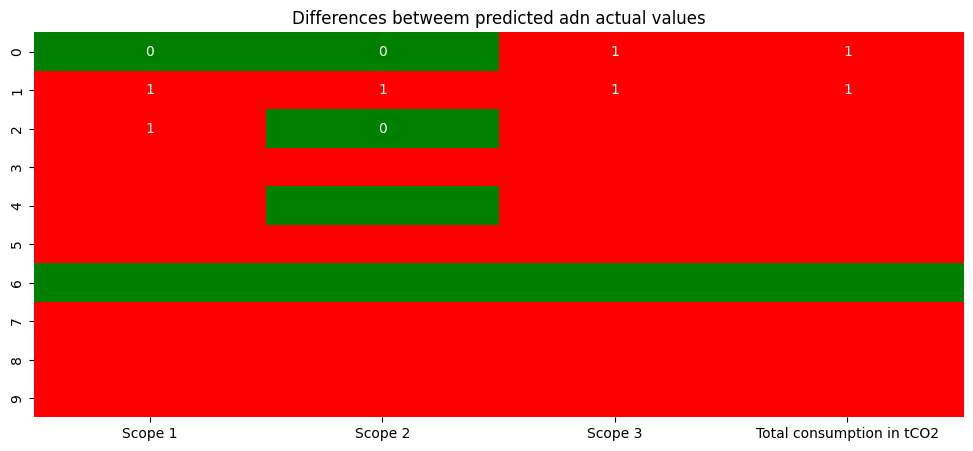

In [200]:
import seaborn as sns
import matplotlib.pyplot as plt
              
plt.figure(figsize = (12,5))

sns.heatmap(comparison_df.applymap(lambda x: 0 if x else 1), annot = True, cmap = ['green', 'red'], cbar = False)
plt.title('Differences betweem predicted adn actual values')

print("Overall accuracy is:", overall_accuracy)

In [162]:
df1

,Group Name,Scope 1,Scope 2,Scope 3,Total consumption in tCO2
0,The House of Bruar,240.00,531.0,45.0,816.00
1,Breeze Motor Group,113.00,83.0,3.0,199.00
2,Formula One Auto Centres Limited,462.35,1171.2,0.0,1633.55
3,Commercial Corporate Services Limited,206.60,67.1,16.8,290.50
4,J. H. Leeke and Sons Limited,2279.00,1784.0,55.0,4118.00
5,Aces Academies Trust,597.59,216.4,0.0,813.99
6,Underwood Meat Company Limited,695.00,639.0,4.0,1338.00
7,NCR Financial Solutions Group Limited,248.00,565.0,6.0,819.00
8,Special Steel Group,1285.50,370.3,0.2,1656.00
9,NWH Group Limited,8374.00,202.0,2035.0,10594.00


In [132]:
print(result_df)
print("Overall accuracy for columns to compare:", overall_accuracy)

          Scope 1         Scope 2         Scope 3 Total consumption in tCO2
0  False   True  False            False
1  False  False  False            False
2  False  False  False            False
3  False  False  False            False
4  False   True  False            False
5  False  False  False            False
6  False   True   True             True
7  False  False  False            False
8  False  False  False            False
9  False  False  False            False
Overall accuracy for columns to compare: 0.125


## Creating the data

To test the model, we are using 10 label companies and their publicly available financial/ sustainability reports as validation data. 
The values of interest include emissions for scope 1, 2 and 3 and their total energy consumption in tCO2.


In [140]:
# list the columns
companies = ["The House of Bruar", "Breeze Motor Group", "Formula One Auto Centres Limited", "Commercial Corporate Services Limited", "J. H. Leeke and Sons Limited", 
             "Aces Academies Trust", "Underwood Meat Company Limited","NCR Financial Solutions Group Limited", "Special Steel Group", "NWH Group Limited"]

scope_1 = [240, 113, 462.35, 206.6, 2279, 597.59, 695, 248, 1285.5, 8374]
scope_2 = [531, 83, 1171.2, 67.1, 1784, 216.4, 639, 565, 370.3, 202]
scope_3 = [45, 3, 0, 16.8, 55, 0, 4, 6, 0.2, 2035]
total_energy = [816, 199, 1633.55, 290.5, 4118, 813.99, 1338, 819, 1656, 10594]

df = pd.DataFrame({'Group Name': companies,
                   'Scope 1': scope_1,
                   'Scope 2': scope_2,
                   'Scope 3': scope_3,
                   'Total consumption in tCO2': total_energy})



In [ ]:
# pdf path for each company
# Iterate through the pdfs folder and order the pdfs by first numerical character - mathcing the index of the company in the data frane -

pdf_paths = sorted(glob.glob("validation_pdfs/*.pdf"), key = lambda x : int(x.split('/')[-1][0]) 

# Get text from each pdf using the path 
texts_list = []
                   
for pdf in pdf_paths:
    texts_list.append(text_extraction_from_pdf(pdf))


print(len(texts_list))
df['text'] = texts_list
df.to_csv('df_csv', index = False)

In [189]:
df_companies = pd.read_csv('df_csv')
df_companies

,Group Name,Scope 1,Scope 2,Scope 3,Total consumption in tCO2,text
0,The House of Bruar,240.00,531.0,45.0,816.00,Company Registration No. SC145746 (Scotland)\n...
1,Breeze Motor Group,113.00,83.0,3.0,199.00,Breeze Motor Company\nLimited\nRegistered numb...
2,Formula One Auto Centres Limited,462.35,1171.2,0.0,1633.55,REGISTERED NUMBER: 01437311 (England and Wales...
3,Commercial Corporate Services Limited,206.60,67.1,16.8,290.50,Registration number: 07531759\nCOMMERCIAL CORP...
4,J. H. Leeke and Sons Limited,2279.00,1784.0,55.0,4118.00,COMPANY REGISTRATION NO. 05216515 (England and...
5,Aces Academies Trust,597.59,216.4,0.0,813.99,ACES ACADEMIES TRUST\nGOVERNANCE STATEMENT (CO...
6,Underwood Meat Company Limited,695.00,639.0,4.0,1338.00,Company Registration No. 02716900 (England and...
7,NCR Financial Solutions Group Limited,248.00,565.0,6.0,819.00,NCR Financial Solutions Group Limited\nStateme...
8,Special Steel Group,1285.50,370.3,0.2,1656.00,Company Registration No. 00208641 (England and...
9,NWH Group Limited,8374.00,202.0,2035.0,10594.00,Company Registration No. SC303441 (Scotland)\n...


In [ ]:
# 2. List of prompts: can follow the template [task] + [context, where definition or metrics can be given] + [persona] + [examplars] 
# Give me the scope 1 emissions
# Give me the scope 2 emissions
# Give me the scope 3 emissions
# Give me the total energy consummed in tCO2


notes: 
- list of prompts to use one each data> how can they be improved? 
- create dataframe from answers generate by RAG
- return text chunk used by model as context for answer
- automate loop for evaluation amd model comparison 
- how to choose betweeen the gcp model? try with llama2?


steps: 
1. try extract all texts at once and put into a folder called related txts
2. list of given prompts to test (how to determine which ones are better?)
3. go through thoses txts (one per one) and test given prompt
4. get numbers in answers into a dataframe
5. compare accuracy